In [6]:
# basic
import math
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [12]:
movie_df = pd.read_csv(r"C:\Users\Jeffery\Desktop\Portfolio\movie_recommendation\movies.csv")
rating_df = pd.read_csv(r"C:\Users\Jeffery\Desktop\Portfolio\movie_recommendation\ratings.csv")

movie_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [114]:
rating_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [16]:
# checking for missing data
for col in movie_df.columns:
    missing_percent = np.mean(movie_df[col].isnull())
    print('{} column is missing {}%'.format(col, missing_percent))
    
for col in rating_df.columns:
    missing_percent = np.mean(rating_df[col].isnull())
    print('{} column is missing {}%'.format(col, missing_percent))

movieId column is missing 0.0%
title column is missing 0.0%
genres column is missing 0.0%
userId column is missing 0.0%
movieId column is missing 0.0%
rating column is missing 0.0%
timestamp column is missing 0.0%


In [19]:
num_movie = len(movie_df.movieId.unique())
num_user = len(rating_df.userId.unique())
print('There are {} unique movies and {} unique users'.format(num_movie, num_user))

There are 9742 unique movies and 610 unique users%


In [34]:
# Data Exploration
# looking at the number of rating per rating
rating_count_df = pd.DataFrame(rating_df.groupby(["rating"])["rating"].count())
rating_count_df

,rating
rating,
0.5,1370
1.0,2811
1.5,1791
2.0,7551
2.5,5550
3.0,20047
3.5,13136
4.0,26818
4.5,8551


In [57]:
# including the movies that the users haven't rated
total_count = num_movie * num_user
count_zero_rating = total_count - rating_count_df.sum()["rating"]

rating_count_df1 = rating_count_df.append(
    pd.DataFrame({'rating': count_zero_rating}, index=[0.0]),
    verify_integrity=True,
).sort_index()
rating_count_df1

,rating
0.0,5841784
0.5,1370
1.0,2811
1.5,1791
2.0,7551
2.5,5550
3.0,20047
3.5,13136
4.0,26818
4.5,8551


Text(0, 0.5, 'Number of Rating')

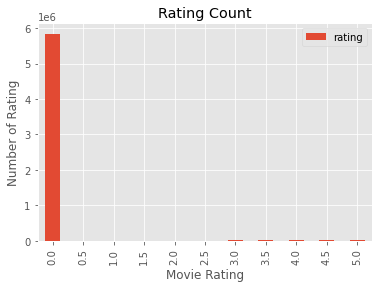

In [97]:
rating_count_df1.plot(kind="bar", title="Rating Count")
plt.xlabel('Movie Rating')
plt.ylabel('Number of Rating')

Text(0, 0.5, 'Number of Rating')

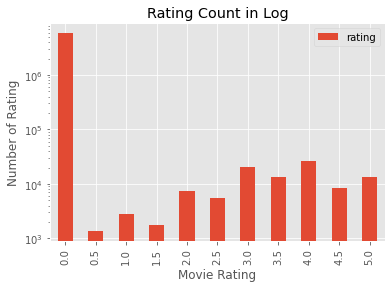

In [81]:
rating_count_df1.plot(kind="bar", title="Rating Count in Log", logy=True)
plt.xlabel('Movie Rating')
plt.ylabel('Number of Rating')

In [106]:
# looking at rating frequency per movie
movie_rating_count_df = pd.DataFrame(rating_df.groupby("movieId")["movieId"].count())
movie_rating_count_df.index.name = None
movie_rating_count_df.head()


,movieId
1,215
2,110
3,52
4,7
5,49


Text(0, 0.5, 'Number of Rating')

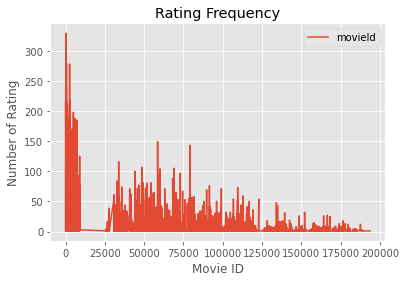

In [109]:
movie_rating_count_df.plot(kind="line")
plt.title("Rating Frequency")
plt.xlabel('Movie ID')
plt.ylabel('Number of Rating')

Text(0, 0.5, 'Number of Rating')

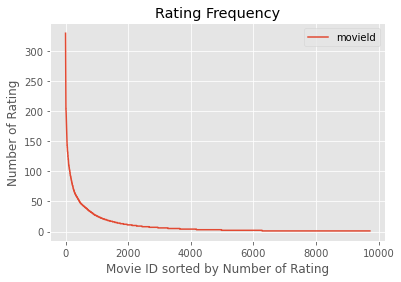

In [111]:
movie_rating_count_df.sort_values("movieId", ascending=False).plot(use_index=False)
plt.title("Rating Frequency")
plt.xlabel('Movie ID sorted by Number of Rating')
plt.ylabel('Number of Rating')

Text(0, 0.5, 'Number of Rating')

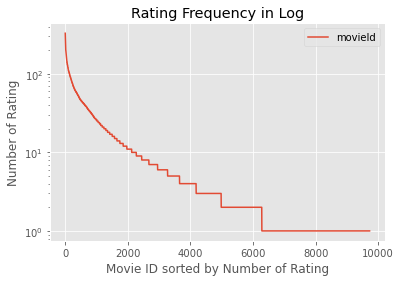

In [113]:
movie_rating_count_df.sort_values("movieId", ascending=False).plot(use_index=False, logy=True)
plt.title("Rating Frequency in Log")
plt.xlabel('Movie ID sorted by Number of Rating')
plt.ylabel('Number of Rating')

In [125]:
# Implementing KNN
movie_features_df = rating_df.pivot(index="movieId", columns="userId", values="rating").fillna(0)
movie_features_df

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193581,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [134]:
# reducing the sparsity
movie_features_csr = csr_matrix(movie_features_df.values)
movie_features_df.reset_index(inplace=True)

In [135]:
knn_model = NearestNeighbors(metric="cosine", algorithm="brute", n_neighbors=20, n_jobs=-1)
knn_model.fit(movie_features_csr)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

In [146]:
# building the function to make recommendations with our KNN model
def make_movie_recommendations(movie_name, n_recommendations):
    """
    """
    # checking if the movie is in the dataframe
    movie_list = movie_df[movie_df["title"].str.contains(movie_name)]
    if len(movie_list):
        # find the movie index
        movie_index_temp = movie_list.iloc[0]["movieId"]
        movie_index = movie_features_df[movie_features_df["movieId"] == movie_index_temp].index[0]
        
        # getting the raw list of index
        distances, indices = knn_model.kneighbors(movie_features_csr[movie_index], n_neighbors=n_recommendations+1)
        recommendation_movie_indices = sorted(list(zip(indices.squeeze().tolist(),distances.squeeze().tolist())),key=lambda x: x[1])[:0:-1]
        
        # adding the movie recommendations into a dataframe
        recommendation_df = []
        for i in recommendation_movie_indices:
            movie_index = movie_features_df.iloc[i[0]]['movieId']
            index = movie_df[movie_df['movieId'] == movie_index].index
            recommendation_df.append({'Title':movie_df.iloc[index]['title'].values[0],'Distance':i[1]})
        df = pd.DataFrame(recommendation_df,index=range(1,n_recommendations+1))
        return df
        
        
        
    

In [147]:
make_movie_recommendations("Iron Man", 10)

,Title,Distance
1,Thor (2011),1.424389e-07
2,District 9 (2009),1.421585e-07
3,X-Men: First Class (2011),1.420724e-07
4,Watchmen (2009),1.404801e-07
5,Sherlock Holmes (2009),1.393209e-07
6,Guardians of the Galaxy (2014),1.382270e-07
7,Star Trek (2009),1.377578e-07
8,Avatar (2009),1.306825e-07
9,Iron Man 2 (2010),1.246204e-07
10,"Avengers, The (2012)",1.172206e-07
